# Event analysis
Investigate Asilomar small-scale array wave statistics from energetic storm event starting on July 13, 2022.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
# from mat73 import loadmat
from scipy.io import loadmat
from scipy import stats, signal
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
mdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/mfiles'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103094 #
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory

# Nortek Vector ADVs
data_vec = os.path.join(rootdir, 'Vectors', 'Level1', 'netcdf_old')
fns_vec = sorted(glob.glob(os.path.join(data_vec, '*Vec*.nc')))

# Output figure directory
figdir  = os.path.join(rootdir, 'Vectors', 'Level1', 'img')
if not os.path.isdir(figdir):
    os.mkdir(figdir)

# Read Olavo's .mat file with Large-Scale Array mooring statistics
fn_nc_ss = os.path.join(rootdir, 'largescale_seaswell_hs.nc')
if not os.path.isfile(fn_nc_ss):
    fn_mat_times = os.path.join(mdir, 'seaswell_times.mat')
    times = loadmat(fn_mat_times)['times'].squeeze()
    # Convert time array to numerical format
    ref_date = pd.Timestamp('2022-06-01') # Reference date
    time_units = 'Seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
    dfi = pd.DataFrame(data=np.zeros_like(times), index=pd.to_datetime(times))
    time_vals = date2num(dfi.index.to_pydatetime(), time_units, calendar='standard', 
        has_year_zero=True)
    # Mooring IDs
    fn_csv_mids = os.path.join(mdir, 'seaswell_mids.csv')
    mids = pd.read_csv(fn_csv_mids).keys().values.astype(str)
    # Hs for windsea
    fn_mat_hssea = os.path.join(mdir, 'seaswell_hs_sea.mat')
    hssea = loadmat(fn_mat_hssea)['hs_sea'].squeeze()
    # Hs for swell
    fn_mat_hsswell = os.path.join(mdir, 'seaswell_hs_swell.mat')
    hsswell = loadmat(fn_mat_hsswell)['hs_swell'].squeeze()
    # Hs for swell + sea
    fn_mat_hsseaswell = os.path.join(mdir, 'seaswell_hs_seaswell.mat')
    hsseaswell = loadmat(fn_mat_hsseaswell)['hs_seaswell'].squeeze()
    # fm for windsea
    fn_mat_fmsea = os.path.join(mdir, 'sea_fm.mat')
    fmsea = loadmat(fn_mat_fmsea)['fm_sea'].squeeze()
    # fm for swell
    fn_mat_fmswell = os.path.join(mdir, 'swell_fm.mat')
    fmswell = loadmat(fn_mat_fmswell)['fm_swell'].squeeze()
    # fm for swell + sea
    fn_mat_fmseaswell = os.path.join(mdir, 'seaswell_fm.mat')
    fmseaswell = loadmat(fn_mat_fmseaswell)['fm_seaswell'].squeeze()
    # Bottom depths
    fn_mat_depths = os.path.join(mdir, 'seaswell_depths.mat')
    depths = loadmat(fn_mat_depths)['depths'].squeeze()
    # Save as netcdf
    dss = xr.Dataset(
        data_vars=dict(
            hs_sea=(['time', 'mid'], hssea),
            hs_swell=(['time', 'mid'], hsswell),
            hs_seaswell=(['time', 'mid'], hsseaswell),
            fm_sea=(['time', 'mid'], fmsea),
            fm_swell=(['time', 'mid'], fmswell),
            fm_seaswell=(['time', 'mid'], fmseaswell),
            depth=(['time', 'mid'], depths),
        ),
        coords=dict(
            time=(['time'], time_vals),
            mid=(['mid'], mids),
        ),
        attrs=dict(description="Large-scale array sea/swell Hs."),
    )
    dss.time.encoding['units'] = time_units
    dss.time.attrs['units'] = time_units
    dss.time.attrs['standard_name'] = 'time'
    dss.time.attrs['long_name'] = 'Local time (PDT), midpoints of sampling intervals'
    # Set encoding before saving
    encoding = {'time': {'zlib': False, '_FillValue': None},
                'mid': {'zlib': False, '_FillValue': None},
                }
    # Set variable fill values
    fillvalue = -9999.
    for k in list(dss.keys()):
        encoding[k] = {'_FillValue': fillvalue}
    # Save to netCDF
    dss.to_netcdf(fn_nc_ss, encoding=encoding)
else:
    dss = xr.decode_cf(xr.open_dataset(fn_nc_ss, decode_coords='all'))


Plot time series of sea/swell Hs

Durations, E1: 1 days 00:00:00, E2: 1 days 00:00:00, E3: 1 days 00:00:00
Mean Hs ratios, E1: 1.53, E2: 11.64, E3: 3.36


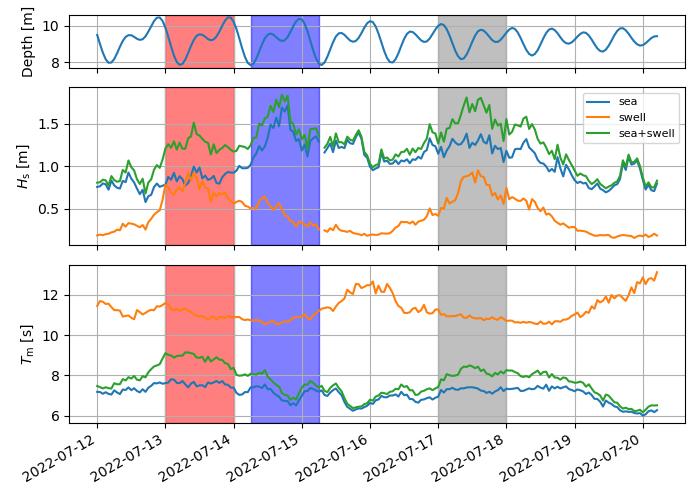

In [2]:
mid = 'X05'
# Crop plot to large wave event towards end of experiment
t0 = pd.Timestamp('2022-07-12 00:00:00')
t1 = pd.Timestamp('2022-07-21 00:00:00')
# Event start/end timestamps
t0_e1 = pd.Timestamp('2022-07-13 00:00:00')
t1_e1 = pd.Timestamp('2022-07-14 00:00:00')
t0_e2 = pd.Timestamp('2022-07-14 06:00:00')
t1_e2 = pd.Timestamp('2022-07-15 06:00:00')
t0_e3 = pd.Timestamp('2022-07-17 00:00:00')
t1_e3 = pd.Timestamp('2022-07-18 00:00:00')
edict = {'E1': [t0_e1, t1_e1], 'E2': [t0_e2, t1_e2], 'E3': [t0_e3, t1_e3], }
print('Durations, E1: {}, E2: {}, E3: {}'.format(t1_e1-t0_e1, t1_e2-t0_e2, t1_e3-t0_e3))
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, gridspec_kw={'height_ratios':[1,3,3]})
# Depth on top
dss.depth.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[0])
# Hs on 2nd row
# ax2 = axes[1].twinx()
dss.hs_sea.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='sea')
dss.hs_swell.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='swell')
dss.hs_seaswell.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='sea+swell')
# Tm on 3rd row
# ax2 = axes[1].twinx()
(1 / dss.fm_sea).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
(1 / dss.fm_swell).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
(1 / dss.fm_seaswell).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
# (dss.hs_sea / dss.hs_swell).sel(mid=mid, time=slice(t0, t1)).plot(
#     ax=ax2, color='r', linestyle='--')
for ax in axes:
    ax.axvspan(t0_e1, t1_e1, alpha=0.5, color='r')
    ax.axvspan(t0_e2, t1_e2, alpha=0.5, color='b')
    ax.axvspan(t0_e3, t1_e3, alpha=0.5, color='gray')
    ax.grid()
    ax.set_title(None)
    ax.set_xlabel(None)
axes[0].set_ylabel(r'Depth [m]')
axes[1].set_ylabel(r'$H_\mathrm{s}$ [m]')
axes[2].set_ylabel(r'$T_\mathrm{m}$ [s]')
# ax2.set_ylabel(r'$H_\mathrm{s, sea} / H_\mathrm{s, swell}$ [m]')
axes[1].legend(fontsize=8)

# Print Hs ratios for each event
re1 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e1, t1_e1)).mean().item()
re2 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e2, t1_e2)).mean().item()
re3 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e3, t1_e3)).mean().item()
print('Mean Hs ratios, E1: {:.2f}, E2: {:.2f}, E3: {:.2f}'.format(re1, re2, re3))

plt.tight_layout()
plt.show()

## Compute statistics for events

In [37]:
# Event start/end timestamps
# t0_e1 = pd.Timestamp('2022-07-13 00:00:00')
# t1_e1 = pd.Timestamp('2022-07-14 00:00:00')
# t0_e2 = pd.Timestamp('2022-07-14 06:00:00')
# t1_e2 = pd.Timestamp('2022-07-15 06:00:00')
# t0_e3 = pd.Timestamp('2022-07-17 00:00:00')
# t1_e3 = pd.Timestamp('2022-07-18 00:00:00')
t0_e1 = pd.Timestamp('2022-06-25 11:00:00')
t1_e1 = pd.Timestamp('2022-07-04 21:00:00')
t0_e2 = pd.Timestamp('2022-07-05 02:00:00')
t1_e2 = pd.Timestamp('2022-07-05 22:00:00')
t0_e3 = pd.Timestamp('2022-07-06 00:00:00')
t1_e3 = pd.Timestamp('2022-07-14 12:00:00')
edict = {'E1': [t0_e1, t1_e1], 'E2': [t0_e2, t1_e2], 'E3': [t0_e3, t1_e3], }

# Get Signature statistics from C1, C3, C6 and L1
print('Getting Signature data ...')
dsd_s = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [], 
         'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
         'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
         'L1-E1': [], 'L1-E2': [], 'L1-E3': [], 
         'L5-E1': [], 'L5-E2': [], 'L5-E3': [], 
        }
# 20-min mean Eastward velocities
uem_s = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [], 
         'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
         'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
         'L1-E1': [], 'L1-E2': [], 'L1-E3': [],
         'L5-E1': [], 'L5-E2': [], 'L5-E3': [], 
        }
# 20-min mean Northward velocities
unm_s = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [], 
         'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
         'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
         'L1-E1': [], 'L1-E2': [], 'L1-E3': [],
         'L5-E1': [], 'L5-E2': [], 'L5-E3': [], 
        }
# 20-min mean vertical velocities
wm_s = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [], 
        'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
        'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
        'L1-E1': [], 'L1-E2': [], 'L1-E3': [],
        'L5-E1': [], 'L5-E2': [], 'L5-E3': [], 
        }
# 20-min mean sea level
slm_s = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [], 
         'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
         'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
         'L1-E1': [], 'L1-E2': [], 'L1-E3': [],
         'L5-E1': [], 'L5-E2': [], 'L5-E3': [], 
        }

# Zero-crossing stuff (Signatures)
dzcs_s = {}

# Read L5 Signature spectrum file for surrounding depth
fn_l5 = os.path.join(rootdir, 'Signatures', 'Level1', '103206', 'Spectra', 
    'Asilomar_2022_SSA_Signature_103206_spec_AST.nc')
dsl5 = xr.decode_cf(xr.open_dataset(fn_l5, decode_coords='all'))

cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
sers_s = ['103088', '103094', '103110', '103063', '103206'] # Serial #s of Vectors
mids_s = ['C1', 'C3', 'C6', 'L1', 'L5'] # Mooring IDs
# # Iterate over event timestamps and compute statistics
# for ki, k in enumerate(edict.keys()):
#     t0e = edict[k][0]
#     t1e = edict[k][1]
#     print('E{}, t0: {}, t1: {}'.format(ki+1, t0e, t1e))
#     # Iterate over mooring IDs and serial numbers
#     for mid, serv in zip(mids_s, sers_s):
#         # print('mid: {}, ser: {}'.format(mid, serv))
#         # Initialize lists to store zero-crossing data
#         dzc = {'Hw': [], 'Hwn': [], 'Hc':[], 'Hcn':[], 'depth':[],} # DZC
#         timestamps_d = []
#         # Signature netcdf dir.
#         veldir = os.path.join(data_root, '{}'.format(serv)) 
#         date_range = pd.date_range(t0e.floor('1D'), t1e.ceil('1D'), freq='1D')
#         # Iterate over daily nc files
#         for date in date_range:
#             datestr = DT.strftime(date, '%Y%m%d')
#             # Get netcdf file name
#             fn_sig = os.path.join(veldir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(mid, datestr))
#             dss = xr.decode_cf(xr.open_dataset(fn_sig, decode_coords='all'))
#             # Estimate wave heights from 20-min segments
#             burst_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='20T')
#             # Iterate over bursts
#             for bi, t0b in enumerate(burst_range[:-1]):
#                 if t0b <= t0e:
#                     continue
#                 if t0b >= t1e:
#                     continue
#                 # Take out segment
#                 t1b = t0b + pd.Timedelta(minutes=20)
#                 spec_cols = ['ASTd', 'ASTd_eta', 'eta_lin_krms', 'z_hyd', 'vE', 'vN', 'vU2']
#                 seg = dss[spec_cols].sel(time=slice(t0b, t1b)).copy()
#                 # depth = seg.ASTd.mean().item()
#                 # Use L5 depth
#                 depth = dsl5.depth_loc.sel(time=t0b.floor('1H')).item()
#                 # Get zero crossings from linear surface reconstruction
#                 eta = seg.ASTd_eta.to_series() # Convert to pandas
#                 eta = eta.interpolate(method='bfill').interpolate('ffill')
#                 zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='down', minlen=3*4)
#                 # Get mean East & North velocities for averaging
#                 ran = 1 # Range bin for Signature velocities
#                 ue = seg.vE.isel(range=ran).to_series() # Convert to pandas
#                 un = seg.vN.isel(range=ran).to_series() # Convert to pandas
#                 # Get mean vertical velocity for each wave
#                 w = seg.vU2.isel(range=ran).to_series() # Convert to pandas
#                 # Compute wave spectrum
#                 spec = rpws.spec_uvz(z=eta.values.squeeze(), u=ue.values.squeeze(), 
#                     v=un.values.squeeze(), fs=4, fmin=0.05, fmax=0.35)
#                 # Get Hs from spectrum
#                 # Hs = spec.Hm0.item()
#                 Hs = eta.std() * 4
#                 # Add time coordinate to spectrum
#                 spec = spec.assign_coords(time=t0b.floor('20T'))
#                 # Compute Ursell number
#                 kp = rpws.waveno_full(2*np.pi*(1 / spec.Tp_ind.item()), d=depth).item()
#                 mu = (kp * depth)**2 # Shallowness parameter
#                 eps = 2 * np.nanstd(eta.values) / depth
#                 # Ur = eps / mu
#                 Ur = (3/4) * (9.81/(8*np.pi**2)) * (spec.Hm0.item()*spec.Tp_ind.item()**2 / depth**2)
#                 sk = stats.skew(eta.values)
#                 asym = stats.skew(np.imag(signal.hilbert(eta.values)))
#                 spec['skew'] = ([], sk)
#                 spec['asym'] = ([], asym)
#                 spec['Ur'] = ([], Ur)
#                 spec['kpd'] = ([], kp * depth)
#                 spec['hsd'] = ([], Hs / depth)
#                 # Append to dict
#                 dsd_s['{}-E{}'.format(mid, ki+1)].append(spec)
#                 # Extend lists
#                 timestamps_d.extend(eta.index[zc[:-1]])
#                 dzc['Hw'].extend(Hw)
#                 dzc['Hwn'].extend(Hw / Hs) # Normalized wave heights
#                 dzc['Hc'].extend(Hc)
#                 dzc['Hcn'].extend(Hc / Hs) # Normalized crest heights
#                 dzc['depth'].extend(np.ones_like(Hw) * depth)
#                 # Append 20-min mean velocities to dicts
#                 uem_s['{}-E{}'.format(mid, ki+1)].append(ue.mean().item())
#                 unm_s['{}-E{}'.format(mid, ki+1)].append(un.mean().item())
#                 wm_s['{}-E{}'.format(mid, ki+1)].append(w.mean().item())
#                 slm_s['{}-E{}'.format(mid, ki+1)].append(depth)
#         # Combine zero-crossing dicts to pd.DataFrames
#         dfzd_s = pd.DataFrame.from_dict(data=dzc)
#         dfzd_s.index = np.array(timestamps_d)
#         dfzd_s.index = dfzd_s.index.rename('time')
#         # Save to full dict
#         dzcs_s['{}-E{}'.format(mid, ki+1)] = dfzd_s
# 
# # Concatenate spectra
# dsm_s = {}
# for ek in ['E1', 'E2', 'E3']:
#     for mid in mids_s:
#         dsm_s['{}-{}'.format(mid, ek)] = xr.concat(dsd_s['{}-{}'.format(mid, ek)], dim='time')

# Vector data
print('Getting Vector data ...')
# Save spectra and angles for each event in dict
dsd = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# Heading, pitch & roll angles
dsa = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean Eastward velocities
uem = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean CS velocities
csm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean Northward velocities
unm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean LS velocities
lsm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean vertical velocities
wm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
      'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
      'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
      'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
      'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
      'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
     }
# 20-min mean sea level
slm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# Bicoherence dataarrays
dsbc = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
        'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
        'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
        'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
        'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
        'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
       }
# Ratios of velocity spectra measured vs. linear theory from AST; C1, C3 and C6 for now
c3m0_um = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [],
           'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
           'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
          } # Hor. vel. m0, measured
c3m0_ul = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [],
           'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
           'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
          } # Hor. vel. m0, linear theory
c3m0_wm = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [],
           'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
           'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
          } # Ver. vel. m0, measured
c3m0_wl = {'C1-E1': [], 'C1-E2': [], 'C1-E3': [],
           'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
           'C6-E1': [], 'C6-E2': [], 'C6-E3': [], 
          } # Ver. vel. m0, linear theory
# Zero-crossing stuff
dzcs = {}

cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
servs = ['17212', '17219', '17371', '17372', '17376', '17377'] # Serial #s of Vectors
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4'] # Mooring IDs
# Iterate over event timestamps and compute statistics
for ki, k in enumerate(edict.keys()):
    t0e = edict[k][0]
    t1e = edict[k][1]
    print('E{}, t0: {}, t1: {}'.format(ki+1, t0e, t1e))
    # Read vector Level1 netcdf file for mooring C3
    vecd = {} # Dict to store Vector mean velocity datasets
    vecsd = {} # Dict to store Vector std velocity datasets
    dfd = {} # Dict to store (downward) zero-crossing dataframes
    # for mid, serv in zip(mids, servs):
    for mid, serv in zip(['C3'], ['17219']):
        dsl = [] # list for merging/averaging bicoherence dataarrays
        # print('Mooring ID: {}, serial no: {}'.format(mid, serv))
        # Get data dir of daily nc files
        ncdir = os.path.join(rootdir, 'Vectors', 'Level1', mid)
        # List all daily ncfiles
        fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
        # Initialize lists to store zero-crossing data
        dzc = {'Hw': [], 'Hwn': [], 'Hc':[], 'Hcn':[], 'eta_mean':[], 'ucs_mean':[], 
               'uls_mean':[], 'w_mean':[], 'depth': [], 'Hwu': [], 'Hwun': [], 'Hcu': [], 'Hcun': [],} # DZC
        timestamps_d = []
        date_range = pd.date_range(t0e.floor('1D'), t1e.ceil('1D'), freq='1D')
        # Iterate over daily nc files
        for date in date_range:
            datestr = DT.strftime(date, '%Y%m%d')
            print(date)
            # Get netcdf file name
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Also read C3 Sig1000 AST signal
            if mid in ['C1', 'C3', 'C6',]:
                if mid == 'C1':
                    ser_s = '103088'
                if mid == 'C3':
                    ser_s = '103094'
                if mid == 'C6':
                    ser_s = '103110'
                veldir = os.path.join(data_root, '{}'.format(ser_s)) 
                fn_sig = os.path.join(veldir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(mid, datestr))
                dss = xr.decode_cf(xr.open_dataset(fn_sig, decode_coords='all'))
                ast = dss.ASTd_eta.copy()
            if np.all(np.isnan(ast.values)):
                continue
            # Estimate wave heights from bursts
            burst_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
            # Iterate over bursts
            for bi, t0b in enumerate(burst_range[:-1]):
                if t0b <= t0e:
                    continue
                if t0b >= t1e:
                    continue
                # Take out segment
                t1b = t0b + pd.Timedelta(hours=1)
                spec_cols = ['ucs', 'uls', 'uE', 'uN', 'uU', 'eta_lin_krms', 'z_hyd', 'heading_ang',
                             'pitch_ang', 'roll_ang']
                seg = dsv[spec_cols].sel(time=slice(t0b, t1b)).copy()
                depth_loc = seg.z_hyd.mean().item() # Local depth at instrument
                # Use depth from L5 (surrounding depth) for wavenumbers
                depth = dsl5.depth_loc.sel(time=t0b.floor('1H')).item()
                # Get zero crossings from linear surface reconstruction
                eta = seg.eta_lin_krms.to_dataframe() # Convert to pandas
                eta = eta.interpolate(method='bfill').interpolate('ffill')
                if np.all(np.isnan(eta)):
                    continue
                zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=3*16)
#                 # Get mean waterlevel for each wave
#                 _, eta_mean = rpzc.get_waveheights(eta.values, method='down', zero_crossings=zc,
#                     func='mean')
#                 # Get mean East & North velocities for averaging
#                 ue = seg.uE.to_dataframe() # Convert to pandas
#                 # Remove leading/trailing NANs
#                 ue = ue.interpolate(method='bfill').interpolate('ffill')
#                 un = seg.uN.to_dataframe() # Convert to pandas
#                 # Remove leading/trailing NANs
#                 un = un.interpolate(method='bfill').interpolate('ffill')
                # Get mean cross-shore velocity for each wave
                ucs = seg.ucs.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                ucs = ucs.interpolate(method='bfill').interpolate('ffill')
                ucs -= ucs.mean()
#                 # ucs = ucs.dropna()
#                 _, ucs_mean = rpzc.get_waveheights(ucs.values, method='down', zero_crossings=zc,
#                     func='mean')
#                 # Get 'wave heights' from CS velocity
#                 _, Hwu, Hcu, Htu = rpzc.get_waveheights(ucs.values, method='down', minlen=3*16, zero_crossings=zc)
#                 Hsu = np.std(ucs.values.squeeze()) * 4
                # Get mean along-shore velocity for each wave
                uls = seg.uls.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                uls = uls.interpolate(method='bfill').interpolate('ffill')
                uls -= uls.mean()
                # uls = uls.dropna()
#                 _, uls_mean = rpzc.get_waveheights(uls.values, method='down', zero_crossings=zc,
#                     func='mean')
#                 if np.sum(np.isnan(ucs.values)) > 0:
#                     eta = eta.loc[ucs.first_valid_index():]
#                     ucs = ucs.loc[ucs.first_valid_index():]
#                     uls = uls.loc[ucs.first_valid_index():]
                # Get mean vertical velocity for each wave
                w = seg.uU.to_dataframe() # Convert to pandas
                w -= w.mean()
#                 _, w_mean = rpzc.get_waveheights(w.values, method='down', zero_crossings=zc,
#                     func='mean')
#                 # Compute wave spectrum
                spec = rpws.spec_uvz(z=eta.values.squeeze(), u=ucs.values.squeeze(), 
                    v=uls.values.squeeze(), fs=16, fmin=0.05, fmax=0.35)
                # Also estimate AST spectrum from C3 Signature
                # if mid in ['C1', 'C3', 'C6']:
                if mid in ['C3']:
                    seg_ast = ast.sel(time=slice(t0b, t1b)).values
                    spec_ast = rpws.spec_uvz(z=seg_ast, fs=4, fmin=0.05, fmax=0.35)
                    # Save AST bandwidth
                    # spec['nu_AST_C3'] = ([], spec_ast.nu_LH57.item())
                    # Compute (E_uu-measured-vec / E_uu-linear-ast) ratio
                    Euu_vec = (spec.Euu + spec.Evv).values # Velocity spec. from C3 Vector
                    # Compute linear wavenumbers for AST spectrum
                    omega = 2*np.pi * spec_ast.freq.values
                    kl = rpws.waveno_full(omega, d=depth)
                    # kl = rpws.waveno_full(omega, d=8)
                    # Estimate velocity spectrum from AST spectrum using LWT
                    factor = np.cosh(kl * (0.5)) / np.sinh(kl * depth_loc)
                    Euu_lin = spec_ast.Ezz.values * omega**2 * factor**2
                    # Compute ratio of zeroth order moments
                    m0u = rpws.spec_moment(Euu_vec, spec.freq.values, order=0)
                    c3m0_um['{}-E{}'.format(mid, ki+1)].append(m0u)
                    m0z = rpws.spec_moment(Euu_lin, spec_ast.freq.values, order=0)
                    c3m0_ul['{}-E{}'.format(mid, ki+1)].append(m0z)
                    Euu_ratio = m0u / m0z
                    # TODO: Also compute similar ratios for vertical velocities
                    factor_w = np.sinh(kl * (0.5)) / np.sinh(kl * depth_loc)
                    Eww_lin = spec_ast.Ezz.values * omega**2 * factor_w**2
                    spec_w = rpws.spec_uvz(z=w.values.squeeze(), fs=16, fmin=0.05, fmax=0.35)
                    # Compute ratio of zeroth order moments of vertical velocities
                    m0w = rpws.spec_moment(spec_w.Ezz.values, spec_w.freq.values, order=0)
                    c3m0_wm['{}-E{}'.format(mid, ki+1)].append(m0w)
                    m0zz = rpws.spec_moment(Eww_lin, spec_ast.freq.values, order=0)
                    c3m0_wl['{}-E{}'.format(mid, ki+1)].append(m0zz)
                    Eww_ratio = m0w / m0zz
#                 # Get Hs from spectrum
#                 Hs = spec.Hm0.item()
#                 # Add time coordinate to spectrum
#                 spec = spec.assign_coords(time=t0b.floor('1H'))
#                 # Compute Ursell number
#                 kp = rpws.waveno_full(2*np.pi*(1 / spec.Tp_ind.item()), d=depth).item()
#                 mu = (kp * depth)**2 # Shallowness parameter
#                 eps = 2 * np.nanstd(eta.values) / depth
#                 # Ur = eps / mu
#                 Ur = (3/4) * (9.81/(8*np.pi**2)) * (spec.Hm0.item()*spec.Tp_ind.item()**2 / depth**2)
#                 sk = stats.skew(eta.values).item()
#                 asym = stats.skew(np.imag(signal.hilbert(eta.values))).item()
#                 spec['skew'] = ([], sk)
#                 spec['asym'] = ([], asym)
#                 spec['Ur'] = ([], Ur)
#                 spec['kpd'] = ([], kp * depth)
#                 spec['hsd'] = ([], Hs / depth)
#                 # Estimate bispectrum, only save bicoherence for select times
#                 bic_t0s = ['2022-07-13 04:00:00', '2022-07-14 09:00:00', '2022-07-17 09:00:00']
#                 # if str(t0b) in bic_t0s:
#                 dsb = rpws.bispectrum(z=ucs.values.squeeze()[::4], fs=16//4, h0=depth)
#                 dsb = dsb.assign_coords(time=t0b.floor('1H')) # Add time coord.
#                 Bc = dsb.Bc.copy() # Only bicoh
#                 # Mask out non-significant bicoh
#                 Bc = Bc.where(Bc >= dsb.b95.item()).fillna(0)
#                 # Interpolate bicoherence**2 onto frequency/fp normalized grid
#                 f1n = (Bc.freq1 / (1 / spec.Tp_Y95.item()))
#                 f2n = (Bc.freq2 / (1 / spec.Tp_Y95.item()))
#                 # Make target normalized frequencies
#                 nt = 51 # Number of normalized target frequencies
#                 f1nt = np.linspace(0, 5, nt)
#                 f2nt = np.linspace(0, 5, nt)
#                 # Old array to interpolate
#                 old = xr.DataArray(Bc.values, [('f1n', f1n.values), ('f2n', f2n.values)])
#                 # Make new DataArray using target frequencies for interpolation
#                 target = xr.DataArray(np.zeros((nt, nt)), [('f1n', f1nt), ('f2n', f2nt)])
#                 # Interpolate bicoherence to target normalized frequencies
#                 Bci = old.interp_like(target)
#                 # Add time coord to interpolated array
#                 Bci = Bci.assign_coords(time=t0b.floor('1H'))
#                 # Append to list for averaging
#                 dsl.append(Bci)
#                 # Append to dict
#                 dsd['{}-E{}'.format(mid, ki+1)].append(spec)
#                 ksa = ['heading_ang', 'pitch_ang', 'roll_ang']
#                 dsa['{}-E{}'.format(mid, ki+1)].append(seg[ksa])
#                 # Extend lists
#                 timestamps_d.extend(eta.index[zc[:-1]])
#                 dzc['Hw'].extend(Hw)
#                 dzc['Hwn'].extend(Hw / Hs) # Normalized wave heights
#                 dzc['Hwu'].extend(Hwu) # "wave heights" from cross-shore vel.
#                 dzc['Hwun'].extend(Hwu / Hsu) # "wave heights" from cross-shore vel.
#                 dzc['Hcu'].extend(Hcu) # "wave heights" from cross-shore vel.
#                 dzc['Hcun'].extend(Hcu / Hsu) # "wave heights" from cross-shore vel.
#                 dzc['Hc'].extend(Hc)
#                 dzc['Hcn'].extend(Hc / Hs) # Normalized crest heights
#                 dzc['eta_mean'].extend(eta_mean)
#                 dzc['ucs_mean'].extend(ucs_mean)
#                 dzc['uls_mean'].extend(uls_mean)
#                 dzc['w_mean'].extend(w_mean)
#                 dzc['depth'].extend(np.ones_like(Hw) * depth)
#                 # Append 20-min mean velocities to dicts
#                 uem['{}-E{}'.format(mid, ki+1)].append(ue.mean().item())
#                 csm['{}-E{}'.format(mid, ki+1)].append(ucs.mean().item())
#                 unm['{}-E{}'.format(mid, ki+1)].append(un.mean().item())
#                 lsm['{}-E{}'.format(mid, ki+1)].append(uls.mean().item())
#                 wm['{}-E{}'.format(mid, ki+1)].append(w.mean().item())
#                 slm['{}-E{}'.format(mid, ki+1)].append(depth)
#         # Combine zero-crossing dicts to pd.DataFrames
#         dfzd = pd.DataFrame.from_dict(data=dzc)
#         dfzd.index = np.array(timestamps_d)
#         dfzd.index = dfzd.index.rename('time')
#         # Save to full dict
#         dzcs['{}-E{}'.format(mid, ki+1)] = dfzd
# #         # Concatenate bicoherence dataarrays
# #         dsbc['{}-E{}'.format(mid, ki+1)] = xr.concat(dsl, dim='time')


# # Concatenate spectra
# dsm = {}
# for ek in ['E1', 'E2', 'E3']:
#     for mid in mids:
#         dsm['{}-{}'.format(mid, ek)] = xr.concat(dsd['{}-{}'.format(mid, ek)], dim='time')




Getting Signature data ...
Getting Vector data ...
E1, t0: 2022-06-25 11:00:00, t1: 2022-07-04 21:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
E2, t0: 2022-07-05 02:00:00, t1: 2022-07-05 22:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
E3, t0: 2022-07-06 00:00:00, t1: 2022-07-14 12:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


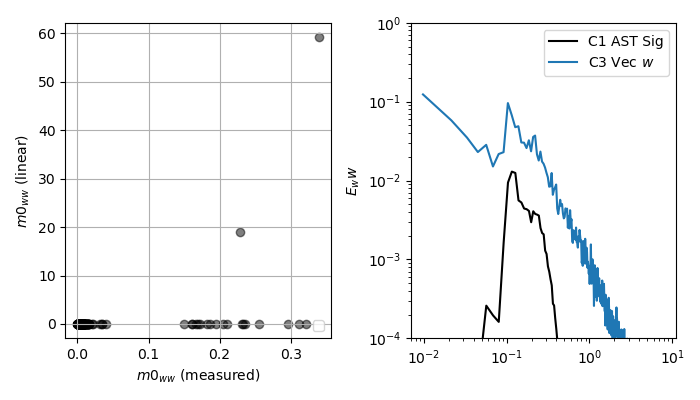

In [38]:
fig, axes = plt.subplots(figsize=(7,4), ncols=2)

# axes[0].plot(np.linspace(0, 0.04), np.linspace(0, 0.04), color='k', linestyle='--', alpha=0.5)
x = np.concatenate([c3m0_wm['C3-E1'], c3m0_wm['C3-E2'], c3m0_wm['C3-E3'], ])
y = np.concatenate([c3m0_wl['C3-E1'], c3m0_wl['C3-E2'], c3m0_wl['C3-E3'], ])
axes[0].scatter(x, y, c='k', alpha=0.5)
# axes[0].scatter(c3m0_wm['C3-E1'], c3m0_wl['C3-E1'], label='C3-E1')
# axes[0].scatter(c3m0_wm['C3-E2'], c3m0_wl['C3-E2'], label='C3-E2')
# axes[0].scatter(c3m0_wm['C3-E3'], c3m0_wl['C3-E3'], label='C3-E3')

# axes[0].set_xlim([0, 0.04])
# axes[0].set_ylim([0, 0.04])
axes[0].grid()
axes[0].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel(r'$m0_{ww}$ (linear)')
axes[0].set_xlabel(r'$m0_{ww}$ (measured)')

axes[1].plot(spec_ast.freq.values, Eww_lin, color='k', label='C1 AST Sig')
axes[1].plot(spec.freq.values, spec_w.Ezz.values, label=r'C3 Vec $w$')

axes[1].set_ylabel(r'$E_ww$')
# axes[1].set_xlim([0.05, 1])
axes[1].set_ylim([1e-4, 1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

c3m0_wm['C6-E1']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


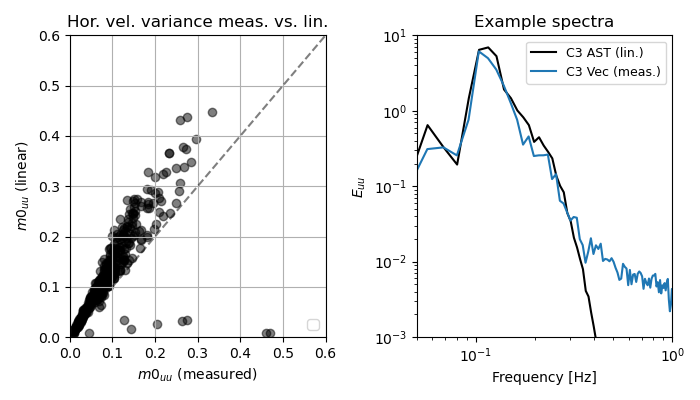

In [39]:
fig, axes = plt.subplots(figsize=(7,4), ncols=2)

x = np.concatenate([c3m0_um['C3-E1'], c3m0_um['C3-E2'], c3m0_um['C3-E3']])
y = np.concatenate([c3m0_ul['C3-E1'], c3m0_ul['C3-E2'], c3m0_ul['C3-E3']])

axes[0].plot(np.linspace(0, 0.6), np.linspace(0, 0.6), color='k', linestyle='--', alpha=0.5)
axes[0].scatter(x, y, c='k', alpha=0.5)
# axes[0].scatter(c3m0_um['C3-E1'], c3m0_ul['C3-E1'], label='C3-E1')
# axes[0].scatter(c3m0_um['C3-E2'], c3m0_ul['C3-E2'], label='C3-E2')
# axes[0].scatter(c3m0_um['C3-E3'], c3m0_ul['C3-E3'], label='C3-E3')

axes[0].set_xlim([0, 0.6])
axes[0].set_ylim([0, 0.6])
axes[0].grid()
axes[0].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel(r'$m0_{uu}$ (linear)')
axes[0].set_xlabel(r'$m0_{uu}$ (measured)')

axes[1].plot(spec_ast.freq.values, Euu_lin, color='k', label='C3 AST (lin.)')
axes[1].plot(spec.freq.values, Euu_vec, label=r'C3 Vec (meas.)')

axes[1].set_ylabel(r'$E_{uu}$')
axes[1].set_xlabel(r'Frequency [Hz]')
axes[1].set_xlim([0.05, 1])
axes[1].set_ylim([1e-3, 10])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].set_title('Example spectra')
axes[0].set_title('Hor. vel. variance meas. vs. lin.')

plt.tight_layout()
plt.show()

Scatter plots of $u$ vs. $w$ for example cases at different moorings.

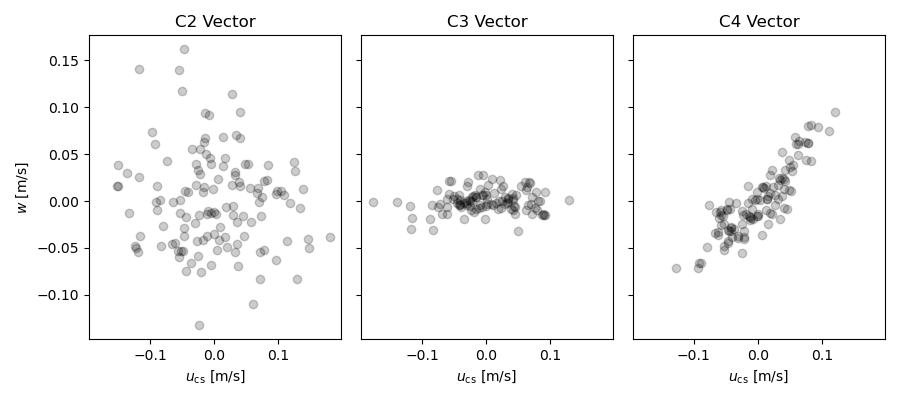

In [58]:
# Read C2, C3, C4 Vector data for given date
t0 = pd.Timestamp('2022-07-04 20:00:00')
t1 = pd.Timestamp('2022-07-04 20:00:10')
# C1
fn_c2 = os.path.join(rootdir, 'Vectors', 'Level1', 'C2', 'Asilomar_SSA_L1_Vec_17212_20220704.nc')
dsv_c2 = xr.decode_cf(xr.open_dataset(fn_c2, decode_coords='all'))
u2 = dsv_c2.ucs.sel(time=slice(t0, t1))
u2 -= u2.mean()
w2 = dsv_c2.uU.sel(time=slice(t0, t1))
w2 -= w2.mean()
# C3
fn_c3 = os.path.join(rootdir, 'Vectors', 'Level1', 'C3', 'Asilomar_SSA_L1_Vec_17219_20220704.nc')
dsv_c3 = xr.decode_cf(xr.open_dataset(fn_c3, decode_coords='all'))
u3 = dsv_c3.ucs.sel(time=slice(t0, t1))
u3 -= u3.mean()
w3 = dsv_c3.uU.sel(time=slice(t0, t1))
w3 -= w3.mean()
# C4
fn_c4 = os.path.join(rootdir, 'Vectors', 'Level1', 'C4', 'Asilomar_SSA_L1_Vec_17371_20220704.nc')
dsv_c4 = xr.decode_cf(xr.open_dataset(fn_c4, decode_coords='all'))
u4 = dsv_c4.ucs.sel(time=slice(t0, t1))
u4 -= u4.mean()
w4 = dsv_c4.uU.sel(time=slice(t0, t1))
w4 -= w4.mean()
# C5
fn_c5 = os.path.join(rootdir, 'Vectors', 'Level1', 'C5', 'Asilomar_SSA_L1_Vec_17372_20220704.nc')
dsv_c5 = xr.decode_cf(xr.open_dataset(fn_c5, decode_coords='all'))
u5 = dsv_c5.ucs.sel(time=slice(t0, t1))
u5 -= u5.mean()
w5 = dsv_c5.uU.sel(time=slice(t0, t1))
w5 -= w5.mean()

# Plot
fig, axes = plt.subplots(figsize=(9,4), ncols=3, sharex=True, sharey=True)
axes[0].scatter(u2, w2, color='k', alpha=0.2)
axes[1].scatter(u3, w3, color='k', alpha=0.2)
axes[2].scatter(u4, w4, color='k', alpha=0.2)
# axes[3].scatter(u5, w5, color='k', alpha=0.2)
axes[0].set_title('C2 Vector')
axes[1].set_title('C3 Vector')
axes[2].set_title('C4 Vector')
# axes[3].set_title('C5 Vector')
axes[0].set_xlabel(r'$u_\mathrm{cs}$ [m/s]')
axes[1].set_xlabel(r'$u_\mathrm{cs}$ [m/s]')
axes[2].set_xlabel(r'$u_\mathrm{cs}$ [m/s]')
# axes[3].set_xlabel(r'$u_\mathrm{cs}$ [m/s]')
axes[0].set_ylabel(r'$w$ [m/s]')

plt.tight_layout()
plt.show()

Phase-resolved orbital velocities from zero-crossing analysis.

In [51]:
# Read C2, C3, C4 Vector data for given date
t0 = pd.Timestamp('2022-07-04 20:00:00')
t1 = pd.Timestamp('2022-07-04 21:00:00')
            
servs = ['17212', '17219', '17371', '17372', '17376', '17377'] # Serial #s of Vectors
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4'] # Mooring IDs
# for mid, serv in zip(mids, servs):
for mid, serv in zip(['C3'], ['17219']):
    dsl = [] # list for merging/averaging bicoherence dataarrays
    # print('Mooring ID: {}, serial no: {}'.format(mid, serv))
    # Get data dir of daily nc files
    ncdir = os.path.join(rootdir, 'Vectors', 'Level1', mid)
    # List all daily ncfiles
    fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
    # Initialize lists to store zero-crossing data
    dzc = {'Hw': [], 'Hwn': [], 'Hc':[], 'Hcn':[], 'eta_mean':[], 'ucs_mean':[], 
            'uls_mean':[], 'w_mean':[], 'depth': [], 'Hwu': [], 'Hwun': [], 'Hcu': [], 'Hcun': [],} # DZC
    timestamps_d = []
    date_range = pd.date_range(t0.floor('1D'), t1.ceil('1D'), freq='1D')
    # Iterate over daily nc files
    for date in date_range:
        datestr = DT.strftime(date, '%Y%m%d')
        print(date)
        # Get netcdf file name
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
        # Estimate wave heights from bursts
        burst_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
        # Iterate over bursts
        for bi, t0b in enumerate(burst_range[:-1]):
            # Take out segment
            t1b = t0b + pd.Timedelta(hours=1)
            print('{} - {}'.format(t0b, t1b))
            spec_cols = ['ucs', 'uls', 'uE', 'uN', 'uU', 'eta_lin_krms', 'z_hyd', 'heading_ang',
                            'pitch_ang', 'roll_ang']
            seg = dsv[spec_cols].sel(time=slice(t0b, t1b)).copy()
            depth_loc = seg.z_hyd.mean().item() # Local depth at instrument
            # Get zero crossings from linear surface reconstruction
            eta = seg.eta_lin_krms.to_dataframe() # Convert to pandas
            eta = eta.interpolate(method='bfill').interpolate('ffill')
            eta -= eta.mean()
            # Cross-shore vel.
            ucs = seg.ucs.to_dataframe() # Convert to pandas
            ucs = ucs.interpolate(method='bfill').interpolate('ffill')
            ucs -= ucs.mean()
            # Vertical vel.
            uw = seg.uU.to_dataframe() # Convert to pandas
            uw = uw.interpolate(method='bfill').interpolate('ffill')
            uw -= uw.mean()
            if np.all(np.isnan(eta)):
                print('all nan eta')
                continue
            # Zero-crossing (up) wave heights
            zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=3*16)
            # Define phase (x) axis to interpolate to
            x_phase = np.linspace(0, 2*np.pi, 160)
            # Initialize lists for soring dataframes of interpolated eta, u, w
            dfw_eta_l = []
            dfw_eta_lin_l = []
            dfw_u_l = []
            dfw_u_lin_l = []
            dfw_w_l = []
            dfw_w_lin_l = []
            # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
            for zi,zc0 in enumerate(zc[:-1]):
                # Wave surface elevation, u and w
                eta_wave = eta.iloc[zc0:zc[zi+1]]
                u_wave = ucs.iloc[zc0:zc[zi+1]]
                w_wave = uw.iloc[zc0:zc[zi+1]]
                # Define phase x axis of wave
                x_wave = np.linspace(0, 1, len(eta_wave)) * 2*np.pi
                # Interpolate to phase
                eta_interp = np.interp(x_phase, x_wave, eta_wave.squeeze())
                u_interp = np.interp(x_phase, x_wave, u_wave.squeeze())
                w_interp = np.interp(x_phase, x_wave, w_wave.squeeze())
                # Save interpolated eta, u_cs and w for each wave in dataframe
                dfw_eta = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): eta_interp}, 
                    index=x_phase)
                dfw_u = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): u_interp}, 
                    index=x_phase)
                dfw_w = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): w_interp}, 
                    index=x_phase)
                # Append to lists
                dfw_eta_l.append(dfw_eta)
                dfw_u_l.append(dfw_u)
                dfw_w_l.append(dfw_w)
                # Compute theoretical LWT values
                fs = 16 # sampling freq.
                T = ((zc[zi+1] - zc0)/16) # wave period in sec.
                omega = 2*np.pi / T # Radian freq. of current wave
                amp = Hw[zi] / 2 # Amplitude from wave height
                t = np.linspace(0, 1, len(x_phase)) * T # time axis
                # Linear surface elevation profile
                eta_lin = amp * np.sin(omega * t) 
                # Theoretical velocities
                k_lin = rpws.waveno_full(omega, d=depth_loc)
                u_lin = omega * amp * (np.cosh(k_lin * 0.5) / np.sinh(k_lin * depth_loc)) * eta_lin
                eta_lin_w = np.cos(omega * t) # Waveform for w
                w_lin = omega * amp * (np.sinh(k_lin * 0.5) / np.sinh(k_lin * depth_loc)) * eta_lin_w
                # Save in dataframes
                dfw_eta_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): eta_lin}, 
                    index=x_phase)
                dfw_u_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): u_lin}, 
                    index=x_phase)
                dfw_w_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): w_lin}, 
                    index=x_phase)
                # Append to list
                dfw_eta_lin_l.append(dfw_eta_lin)
                dfw_u_lin_l.append(dfw_u_lin)
                dfw_w_lin_l.append(dfw_w_lin)
            # Concatenate dataframes
            dfw_eta = pd.concat(dfw_eta_l, axis=1)
            dfw_eta_lin = pd.concat(dfw_eta_lin_l, axis=1)
            dfw_u = pd.concat(dfw_u_l, axis=1)
            dfw_u_lin = pd.concat(dfw_u_lin_l, axis=1)
            dfw_w = pd.concat(dfw_w_l, axis=1)
            dfw_w_lin = pd.concat(dfw_w_lin_l, axis=1)
            raise ValueError


2022-07-04 00:00:00
2022-07-04 00:00:00 - 2022-07-04 01:00:00


ValueError: 

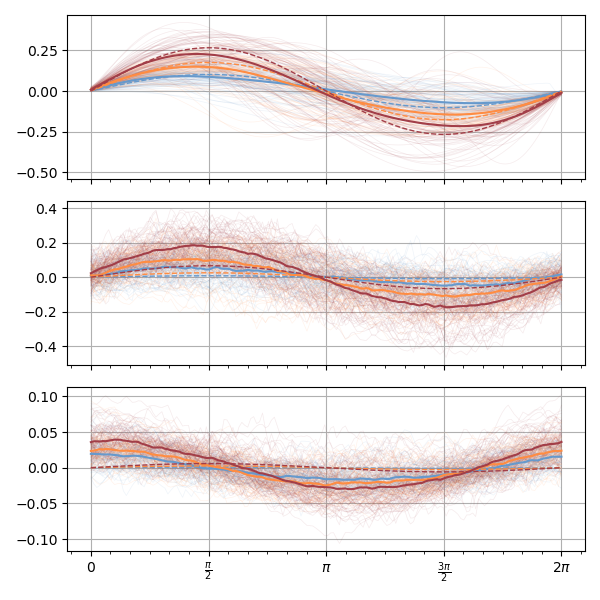

In [52]:
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter

cls = ['#6699CC', '#FF8C42', '#A23E48']
fig, axes = plt.subplots(figsize=(6,6), nrows=3, sharex=True)
N = len(dfw_eta.keys())
# Surf. elevation (all)
dfw_eta.sort_index(axis=1).iloc[:,:N//3].plot(ax=axes[0], linewidth=0.5, alpha=0.1, color=cls[0], 
    legend=False)
dfw_eta.sort_index(axis=1).iloc[:,N//3:2*N//3].plot(ax=axes[0], linewidth=0.5, alpha=0.1, color=cls[1],
    legend=False)
dfw_eta.sort_index(axis=1).iloc[:,2*N//3:].plot(ax=axes[0], linewidth=0.5, alpha=0.1, color=cls[2], 
    legend=False)
# Surf. elevation (mean)
dfw_eta.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.5, color=cls[0])
dfw_eta_lin.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.0, color=cls[0],
    linestyle='--')
dfw_eta.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.5, color=cls[1])
dfw_eta_lin.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.0, color=cls[1],
    linestyle='--')
dfw_eta.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[0], linewidth=1.5, color=cls[2])
dfw_eta_lin.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[0], linewidth=1.0, color=cls[2],
    linestyle='--')
# Cross-shore vel. (all)
dfw_u.sort_index(axis=1).iloc[:,:N//3].plot(ax=axes[1], linewidth=0.5, alpha=0.1, color=cls[0], 
    legend=False)
dfw_u.sort_index(axis=1).iloc[:,N//3:2*N//3].plot(ax=axes[1], linewidth=0.5, alpha=0.1, color=cls[1],
    legend=False)
dfw_u.sort_index(axis=1).iloc[:,2*N//3:].plot(ax=axes[1], linewidth=0.5, alpha=0.1, color=cls[2], 
    legend=False)
# Cross-shore vel. (ensemble avg)
dfw_u.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.5, color=cls[0])
dfw_u_lin.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.0, color=cls[0],
    linestyle='--')
dfw_u.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.5, color=cls[1])
dfw_u_lin.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.0, color=cls[1],
    linestyle='--')
dfw_u.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[1], linewidth=1.5, color=cls[2])
dfw_u_lin.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[1], linewidth=1.0, color=cls[2],
    linestyle='--')
# Vertical vel. (all)
dfw_w.sort_index(axis=1).iloc[:,:N//3].plot(ax=axes[2], linewidth=0.5, alpha=0.1, color=cls[0], 
    legend=False)
dfw_w.sort_index(axis=1).iloc[:,N//3:2*N//3].plot(ax=axes[2], linewidth=0.5, alpha=0.1, color=cls[1],
    legend=False)
dfw_w.sort_index(axis=1).iloc[:,2*N//3:].plot(ax=axes[2], linewidth=0.5, alpha=0.1, color=cls[2], 
    legend=False)
# Vertical vel. (ensemble avg)
dfw_w.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.5, color=cls[0])
dfw_w_lin.sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.0, color=cls[0],
    linestyle='--')
dfw_w.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.5, color=cls[1])
dfw_w_lin.sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.0, color=cls[1],
    linestyle='--')
dfw_w.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[2], linewidth=1.5, color=cls[2])
dfw_w_lin.sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[2], linewidth=1.0, color=cls[2],
    linestyle='--')

# axis stuff
for ax in axes:
    ax.grid()
    # Set x axis labels as multiples of pi
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

plt.tight_layout()
plt.show()
# plt.close()

In [48]:
np.sinh(0.5)
depth_loc
k_lin
omega
T

2080

Plot mean circulation around rock for the 3 events.

/tmp/ipykernel_2574966/1704563755.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(dsbat.eastings, dsbat.northings, dsbat.z_utm, vmin=-8.0, vmax=-3.5,


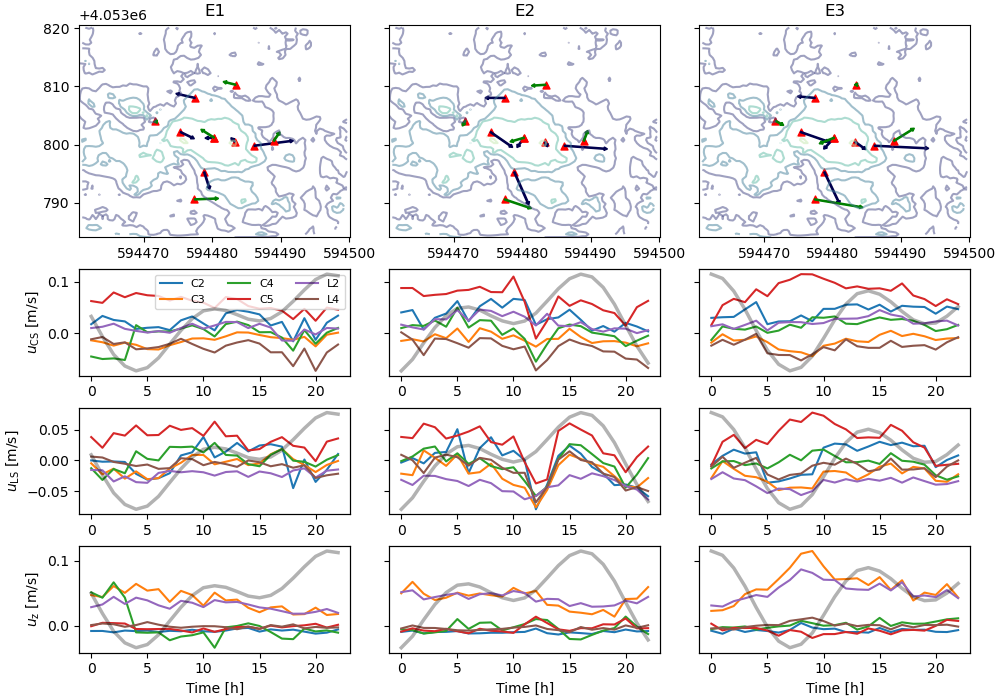

In [43]:
from matplotlib import colors, cm

# From https://stackoverflow.com/questions/73017192/rendering-colors-to-arrows-based-on-an-array-using-matplotlib
V=np.array([[10],[20],[30],[40],[50],[60]])
cmap = plt.cm.seismic
cNorm  = colors.Normalize(vmin=np.min(V), vmax=np.max(V))
scalarMap = cm.ScalarMappable(norm=cNorm,cmap=cmap)

color_list = []        
for idx in range(0,len(V)):
        colorVal = scalarMap.to_rgba(V[idx])
        r,g,b,a = colorVal[0].tolist()
        color_list.append((r,g,b,a))

eks = ['E1', 'E2', 'E3'] # Event strings
# Initialize figure and plot
fig, axes = plt.subplots(figsize=(10,7), ncols=3, nrows=4, constrained_layout=True, sharex='row', sharey='row',
    gridspec_kw={'height_ratios':[2,1,1,1]})
# Iterate over axes (i.e. events) and plot bathymetry
for i,ax in enumerate(axes[0,:]):
    ax.contour(dsbat.eastings, dsbat.northings, dsbat.z_utm, vmin=-8.0, vmax=-3.5,
                cmap=cmocean.cm.deep_r, levels=3, alpha=0.5, linewidth=0.75)
    # Title: event number
    ax.set_title(eks[i])
    # Mean velocity arrows at mooring locations
    s = 25 # Mooring location marker size
    # Vector mean velocities
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        u = np.nanmean(uem['{}-{}'.format(mid, eks[i])]) # east vel.
        v = np.nanmean(unm['{}-{}'.format(mid, eks[i])]) # north vel.
        w = np.nanmean(wm['{}-{}'.format(mid, eks[i])]) # vertical vel.
        umag = np.sqrt(u**2 + v**2)
        # Mooring x,y coordinates (UTM)
        xm = dsbat['{}_utm'.format(mid)][0].item()
        ym = dsbat['{}_utm'.format(mid)][1].item()
        fact = 100 # Arrow length factor
        ax.scatter(xm, ym, marker='^', color='r', s=s)
        ax.arrow(xm, ym, dx=u*fact, dy=v*fact, width=0.2, head_length=0.5, 
                fc=color_list[0], ec=color_list[0], length_includes_head=True,)
    # Signature mean velocities
    for mid in ['C1', 'C3', 'C6', 'L1', 'L5']:
        u = np.nanmean(uem_s['{}-{}'.format(mid, eks[i])]) # east vel.
        v = np.nanmean(unm_s['{}-{}'.format(mid, eks[i])]) # north vel.
        w = np.nanmean(wm_s['{}-{}'.format(mid, eks[i])]) # vertical vel.
        umag = np.sqrt(u**2 + v**2)
        # Mooring x,y coordinates (UTM)
        xm = dsbat['{}_utm'.format(mid)][0].item()
        ym = dsbat['{}_utm'.format(mid)][1].item()
        fact = 100 # Arrow length factor
        ax.scatter(xm, ym, marker='^', color='r', s=s)
        ax.arrow(xm, ym, dx=u*fact, dy=v*fact, width=0.2, head_length=0.5, 
                fc='g', ec='g', length_includes_head=True,)
# Plot 20-min. mean CS velocities per event on second row
for i,ax in enumerate(axes[1,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        # Mean sea level in background (on second axis)
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        u = np.array(uem['{}-{}'.format(mid, eks[i])]) # cross-shore vel.
        v = np.array(unm['{}-{}'.format(mid, eks[i])]) # long-shore vel.
        umag = np.sqrt(u**2 + v**2)
        ax.plot(time, u, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{CS}$ [m/s]')
# Plot 20-min. mean LS velocities per event on second row
for i,ax in enumerate(axes[2,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        v = np.array(lsm['{}-{}'.format(mid, eks[i])]) # long-shore vel.
        umag = np.sqrt(u**2 + v**2)
        ax.plot(time, v, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{LS}$ [m/s]')
# Vertical velocities on bottom
for i,ax in enumerate(axes[3,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        w = np.array(wm['{}-{}'.format(mid, eks[i])]) # vertical vel.
        ax.plot(time, w, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{z}$ [m/s]')
        ax.set_xlabel('Time [h]')
axes[1,0].legend(fontsize=8, ncol=3)

plt.show()
# plt.clf()

E1 nu: 0.32, Tp: 9.89
E2 nu: 0.34, Tp: 8.32
E3 nu: 0.36, Tp: 8.95


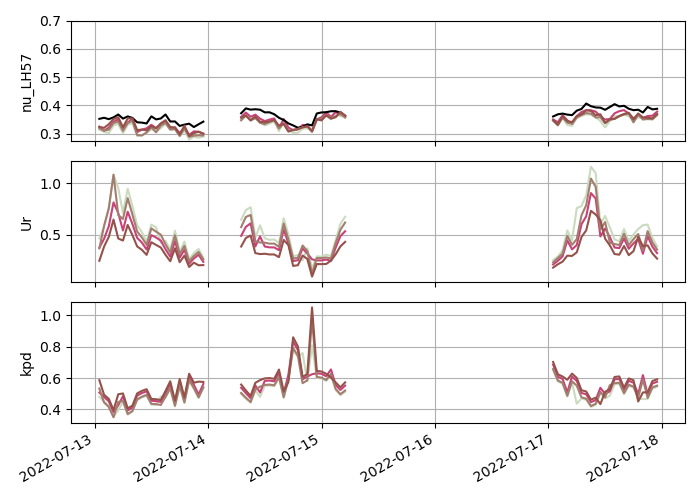

In [44]:
mids = ['C2', 'C3', 'C4', 'C5', ]#'L2', 'L4'] # Mooring IDs
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True)
for ek in ['E1', 'E2', 'E3']:
    nus = [] # List for averaging bandwidths
    tps = [] # List for averaging peak periods
    for mi, mid in enumerate(mids):
        dsm['{}-{}'.format(mid, ek)].nu_LH57.plot(ax=axes[0], color=cs[mi])
        if mid == 'C3':
            dsm['{}-{}'.format(mid, ek)].nu_AST_C3.plot(ax=axes[0], color='k')
        dsm['{}-{}'.format(mid, ek)].Ur.plot(ax=axes[1], color=cs[mi])
        dsm['{}-{}'.format(mid, ek)].kpd.plot(ax=axes[2], color=cs[mi])
        nus.append(dsm['{}-{}'.format(mid, ek)].nu_LH57.mean().item())
        tps.append(dsm['{}-{}'.format(mid, ek)].Tp_ind.mean().item())
    print('{} nu: {:.2f}, Tp: {:.2f}'.format(ek, np.mean(nus), np.mean(tps)))
axes[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
for ax in axes:
    ax.set_xlabel(None)
    ax.grid()
plt.tight_layout()
plt.show()
# eta

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

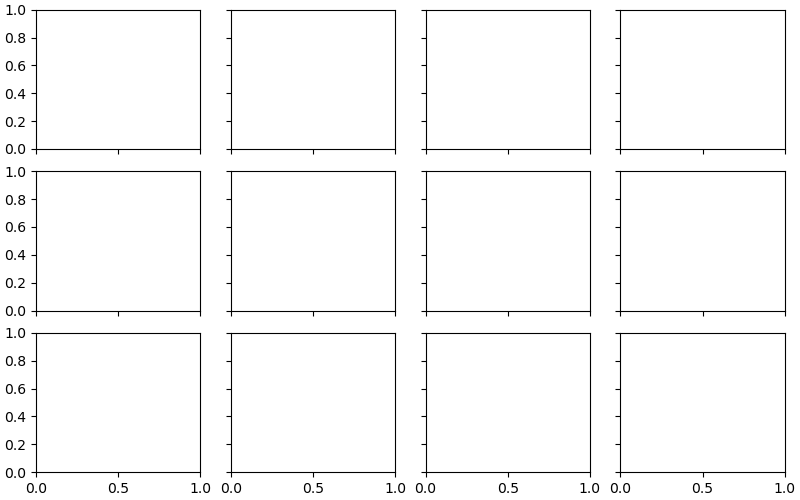

In [45]:
# Plot bicoherence for select times
fig, axes = plt.subplots(figsize=(8,5), ncols=4, nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei,mi]
        im = (dsbc['{}-{}'.format(mid, ek)]**2).mean(dim='time').plot.pcolormesh(ax=ax, add_colorbar=False,
            vmin=0, vmax=0.04)
        ax.set_xlabel(None)
        if mi == 0:
            ax.set_ylabel(r'$b^2(f_1, f_2)$'+'\n{}'.format(ek))
        else:
            ax.set_ylabel(None)
        if ei == 0:
            ax.set_title(mid)
        ax.set_xlim([0,2.5])
        ax.set_ylim([0,2.5])

        if mi == 3:
            cax = ax.inset_axes([1.02, 0.0, 0.03, 1.0])
            fig.colorbar(im, ax=ax, cax=cax)

# plt.tight_layout()
plt.show()

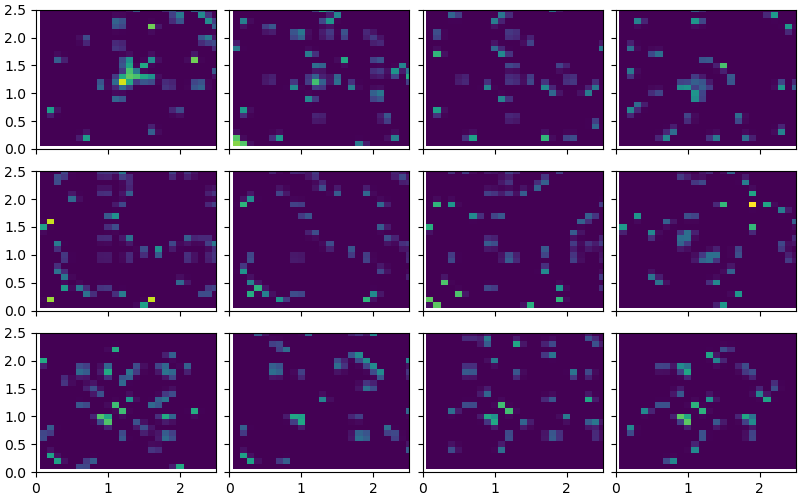

In [356]:
# Plot bicoherence for select times
fig, axes = plt.subplots(figsize=(8,5), ncols=4, nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei,mi]
        if ek == 'E1':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-13 04:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        elif ek == 'E2':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-14 09:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        elif ek == 'E3':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-17 09:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(None)
        ax.set_xlim([0,2.5])
        ax.set_ylim([0,2.5])

# plt.tight_layout()
plt.show()

Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.00
Mean bicoh: 0.00
Mean bicoh: 0.00
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.00
Mean bicoh: 0.01


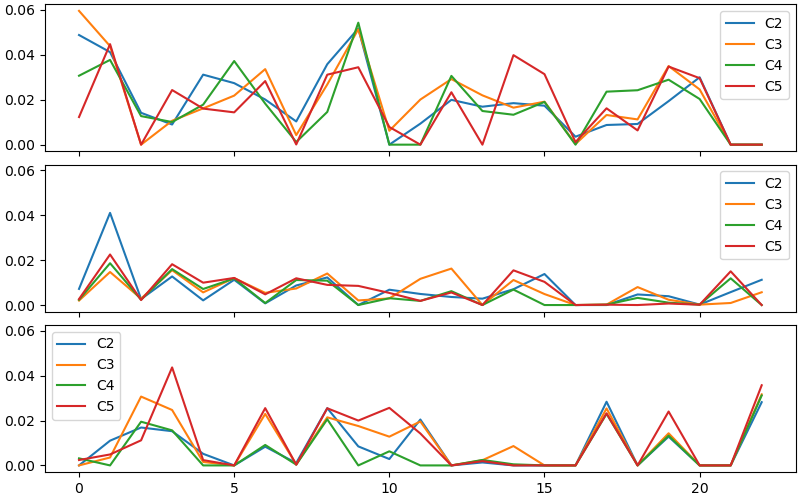

In [420]:
# Plot bicoherence at peak frequency
fig, axes = plt.subplots(figsize=(8,5), nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei]
        ax.plot((dsbc['{}-{}'.format(mid, ek)].sel(f1n=slice(0.9, 1.1), f2n=slice(0.9, 1.1))**2).mean(
            dim=['f1n', 'f2n']), label=mid)
        print('Mean bicoh: {:.2f}'.format((dsbc['{}-{}'.format(mid, ek)].sel(
            f1n=slice(0.75, 1.25), f2n=slice(0.75, 1.25))**2).mean(
                dim=['f1n', 'f2n']).mean()))
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(None)
    ax.legend()

# plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'sel'

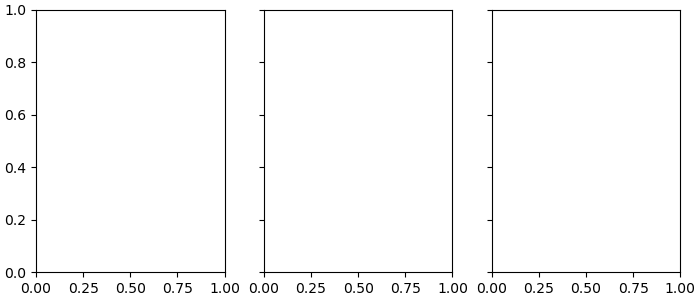

In [46]:
fig, axes = plt.subplots(figsize=(7,3), ncols=3, sharex=True, sharey=True,
                         constrained_layout=True)
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi,mid in enumerate(mids):
        y = dsbc['{}-{}'.format(mid, ek)].sel(f1n=slice(0.75, 1.25), f2n=slice(0.75, 1.25)).mean(
                    dim=['f1n', 'f2n'])
        x = dsm['{}-{}'.format(mid, ek)].Ur.values
        axes[ei].scatter(x, y, c=cs[mi])
plt.tight_layout()
plt.show()

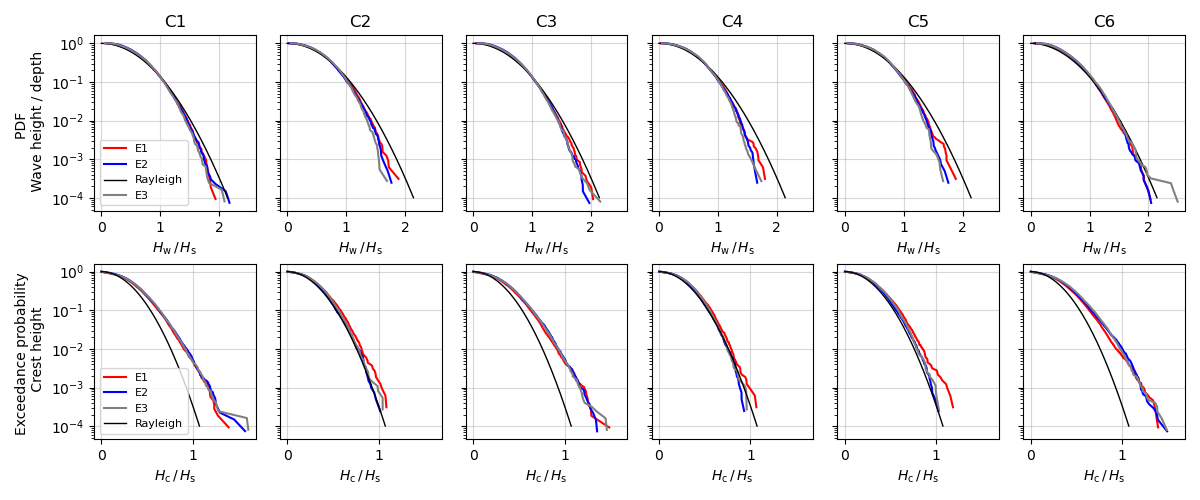

In [69]:
fig, axes = plt.subplots(figsize=(12,5), ncols=6, nrows=2, sharex='row', sharey='row')
mids = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[1,mi]
        # Get xy axes for wave height distributions
        if mid in ['C1', 'C3', 'C6']:
            # Signature AST crest/wave heights
            x = dzcs_s['{}-{}'.format(mid, ek)].Hcn.values # Norm. wave heights
        else:
            # Vector
            x = dzcs['{}-{}'.format(mid, ek)].Hcn.values # Norm. wave heights
        # Get probabilities for y axis
        y, std = rpzc.exceedance_prob(x)
        # Plot distribution in semilogy
        ax.semilogy(np.sort(x), y, label=ek, color=cs[ei])
        ax.grid(alpha=0.5)
        ax.set_xlabel(r'$H_\mathrm{c} \, / \, H_\mathrm{s}$')
        # Plot Rayleigh distribution (just once)
        if ei == 2:
            xrr = np.linspace(0, 2.5, 500)
            peta4 = np.exp(-8*(xrr**2)) # Crest heights
            # peta4 = np.exp(-2*(xrr**2)) # Wave heights
            ind = np.where(peta4 >= 0.0001) # (only down to 10^-5)
            ax.semilogy(xrr[ind], peta4[ind], color='k', linestyle='-', label='Rayleigh',
                        linewidth=1)
            # Tayfun 2nd-order curve
            if mid in ['C1', 'C3', 'C6']:
                # Signatures
                specs = dsm_s['{}-{}'.format(mid, ek)] # Spectra for event
            else:
                # Vectors
                specs = dsm['{}-{}'.format(mid, ek)] # Spectra for event
            # Get average skewness for Tayfun distr.
            skew = specs.skew.mean(dim='time').item()
            tayf = np.exp(-(-1 + np.sqrt(1 + 8*skew*xrr))**2 / (2 * skew**2))
            ind = np.where(tayf >= 0.0001) 
#             ax.semilogy(xrr[ind], tayf[ind], color='k', linestyle=':', label='Tayfun',
#                         linewidth=1)
        # Distributions of wave heights / depth on upper row
        if mid in ['C1', 'C3', 'C6']:
            # Signature wave heights
            hw = dzcs_s['{}-{}'.format(mid, ek)].Hwn.values
            d = dzcs_s['{}-{}'.format(mid, ek)].depth.values
        else:
            # Vector wave heights
            hw = dzcs['{}-{}'.format(mid, ek)].Hwn.values
            d = dzcs['{}-{}'.format(mid, ek)].depth.values
        # Get probabilities for y axis
        yw, std = rpzc.exceedance_prob(hw)
        # Plot Rayleigh distribution (just once)
        if ei == 2:
            xrr = np.linspace(0, 2.5, 500)
            # peta4 = np.exp(-8*(xrr**2)) # Crest heights
            peta4 = np.exp(-2*(xrr**2)) # Wave heights
            ind = np.where(peta4 >= 0.0001) # (only down to 10^-5)
            axes[0,mi].semilogy(xrr[ind], peta4[ind], color='k', linestyle='-', label='Rayleigh',
                        linewidth=1)
        hwd = hw / d
        # print('Max Hw/d = {:.2f}'.format(np.max(hwd)))
        # axes[0,mi].hist(hw, bins=25, color=cs[ei], density=True, histtype='step', label=ek)
        axes[0,mi].semilogy(np.sort(hw), yw, label=ek, color=cs[ei])
        axes[0,mi].set_title(mid)
        # axes[0,mi].set_xticks([0, 0.26, 0.52, 0.78])
        axes[0,mi].grid(alpha=0.5)
        axes[0,mi].set_xlabel(r'$H_\mathrm{w} \, / \, H_\mathrm{s}$')#\, / \, d$')

axes[1,0].legend(fontsize=8)
axes[0,0].legend(fontsize=8)
axes[0,0].set_ylabel('PDF \n Wave height / depth')
axes[1,0].set_ylabel('Exceedance probability \n Crest height')
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

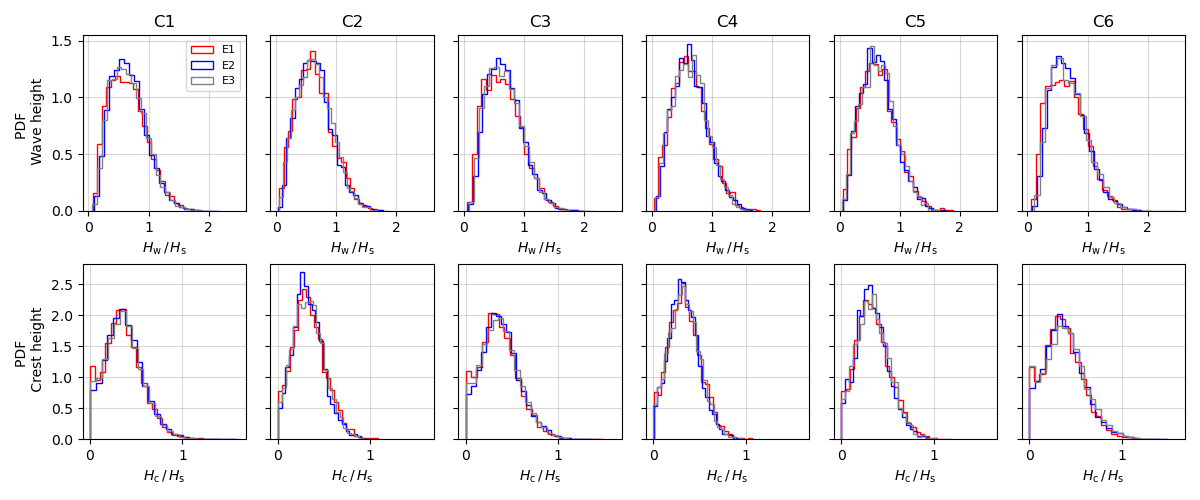

In [78]:
fig, axes = plt.subplots(figsize=(12,5), ncols=6, nrows=2, sharex='row', sharey='row')
mids = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        # Wave heights on upper row
        ax = axes[0,mi]
        # Distributions of wave heights / depth on upper row
        if mid in ['C1', 'C3', 'C6']:
            # Signature wave heights
            hw = dzcs_s['{}-{}'.format(mid, ek)].Hwn.values
            d = dzcs_s['{}-{}'.format(mid, ek)].depth.values
        else:
            # Vector wave heights
            hw = dzcs['{}-{}'.format(mid, ek)].Hwn.values
            d = dzcs['{}-{}'.format(mid, ek)].depth.values
        hwd = hw / d
        ax.hist(hw, bins=25, color=cs[ei], density=True, histtype='step', label=ek)
        ax.set_title(mid)
        ax.grid(alpha=0.5)
        ax.set_xlabel(r'$H_\mathrm{w} \, / \, H_\mathrm{s}$')#\, / \, d$')
        # Crest heights on upper row
        ax = axes[1,mi]
        # Distributions of wave heights / depth on upper row
        if mid in ['C1', 'C3', 'C6']:
            # Signature wave heights
            hc = dzcs_s['{}-{}'.format(mid, ek)].Hcn.values
        else:
            # Vector wave heights
            hc = dzcs['{}-{}'.format(mid, ek)].Hcn.values
        ax.hist(hc, bins=25, color=cs[ei], density=True, histtype='step', label=ek)
        ax.grid(alpha=0.5)
        ax.set_xlabel(r'$H_\mathrm{c} \, / \, H_\mathrm{s}$')#\, / \, d$')

axes[0,0].legend(fontsize=8)
axes[0,0].set_ylabel('PDF \n Wave height')
axes[1,0].set_ylabel('PDF \n Crest height')
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()